In [1]:
import numpy as np
import pandas as pd
import torch
import torch.utils.data as td
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import matplotlib.colors as colors

froot = './data/k562_main'

df = pd.read_csv(froot + ".csv")

In [2]:
print(df.head())

   seqnames    start      end strand  ensembl_gene_id  score      ctcf  \
0         1  3859709  3859709      +  ENSG00000169598    0.0 -0.010876   
1         1  3859710  3859710      +  ENSG00000169598    0.0 -0.010887   
2         1  3859711  3859711      +  ENSG00000169598    0.0 -0.010902   
3         1  3859712  3859712      +  ENSG00000169598    0.0 -0.010920   
4         1  3859713  3859713      +  ENSG00000169598    0.0 -0.010941   

   h3k36me3   h3k4me1  h3k79me2  ...       sj3       dms      rpts  wgbs  \
0  0.353765 -0.078256 -0.156547  ... -0.057178 -0.307549  0.249626   0.0   
1  0.347003 -0.077117 -0.155891  ... -0.057178 -0.307549  0.249626   0.0   
2  0.340295 -0.075994 -0.155236  ... -0.057178 -0.307549  0.249626   0.0   
3  0.333641 -0.074887 -0.154583  ... -0.057178 -0.307549  0.249626   0.0   
4  0.327043 -0.073795 -0.153930  ... -0.057178 -0.307549  0.249626   0.0   

       A         T         G         C  lambda_alphaj      zeta  
0 -0.625 -0.678443  1.954571 -0.

In [3]:
df['gene_length'] = df.groupby('ensembl_gene_id')['ensembl_gene_id'].transform('count')

In [4]:
column_names = df.columns.tolist()
feature_names = column_names[6:-7]
nucleotides = column_names[-7:-3]
print(feature_names)
print(nucleotides)

# process read counts
X_ji = df.groupby('ensembl_gene_id')['score'].apply(list).tolist() 

# process GLM simulated elongation rates
Z_ji = df.groupby('ensembl_gene_id')['zeta'].apply(list).tolist() 

num_samples = len(X_ji)

['ctcf', 'h3k36me3', 'h3k4me1', 'h3k79me2', 'h3k9me1', 'h3k9me3', 'h4k20me1', 'sj5', 'sj3', 'dms', 'rpts', 'wgbs']
['A', 'T', 'G', 'C']


In [5]:
print(num_samples)

1502


In [7]:
def sliding_window(data, window_size):
    data = np.array(data)  # Convert data to a NumPy array for efficient operations
    num_sites = len(data)
    
    sub_sequences = []
    
    for i in range(num_sites):
        start = i - window_size // 2
        end = i + window_size // 2 + 1  # +1 to include the right edge
        
        # Ensure that the window is within the bounds of the sequence
        if start < 0:
            padding_start = abs(start)
            start = 0
        else:
            padding_start = 0
        
        if end > num_sites:
            padding_end = end - num_sites
            end = num_sites
        else:
            padding_end = 0
        
        window = data[start:end]
        
        # Pad the window if necessary
        if padding_start > 0 or padding_end > 0:
            window = np.pad(window, (padding_start, padding_end), mode='constant')
        
        sub_sequences.append(window)
    
    return sub_sequences

window_size = 201  # 100 sites to the left, 100 sites to the right, and the target site

In [ ]:
X_ji_windows = []
for seq in X_ji:
    x_windows = sliding_window(seq, window_size)
    X_ji_windows.extend(x_windows)

In [13]:
Z_ji_windows = []
for seq in Z_ji:
    z_windows = sliding_window(seq, window_size)
    Z_ji_windows.extend(z_windows)

In [19]:
C_j = df.groupby('ensembl_gene_id')['lambda_alphaj'].apply(list).tolist() 

In [28]:
C_j_windows = []
for seq in C_j:
    c_windows = sliding_window(seq, window_size)
    C_j_windows.extend(c_windows)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

#Y_ji is a list of samples containing lists of their feature values
    # [   
    #   [[sample_1_feature_1], [sample_1_feature_2], [sample_1_feature_3]],
    #   [[sample_2_feature_1], [sample_2_feature_2], [sample_2_feature_3]],  
    # ]

Y_ji = []

for sample_id in df['ensembl_gene_id'].unique():
    sample_data = [df[feature_name][df['ensembl_gene_id'] == sample_id].tolist() for feature_name in feature_names]
    Y_ji.append(sample_data)

In [ ]:
# normalize features
scaler = MinMaxScaler()
Y_ji = np.array(Y_ji)
# reshape dataset to [num_samples, num_features * feature_length]
Y_ji_reshaped = Y_ji.reshape(Y_ji.shape[0], -1)
normalized_Y_ji_reshaped = scaler.fit_transform(Y_ji_reshaped)
Y_ji = normalized_Y_ji_reshaped.reshape(Y_ji.shape)

In [29]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

class CustomDataset(Dataset):
    def __init__(self, X_ji, C_j, Z_ji):
        #self.Y_ji = Y_ji
        self.X_ji = X_ji
        self.C_j = C_j
        self.Z_ji = Z_ji

    def __len__(self):
        return len(self.X_ji)

    def __getitem__(self, idx):
        return {
            #'Y_ji':  torch.tensor(self.Y_ji[idx], dtype=torch.float32),
            'X_ji': torch.tensor(self.X_ji[idx], dtype=torch.float32),
            'C_j': torch.tensor(self.C_j[idx], dtype=torch.float32),
            'Z_ji': torch.tensor(self.Z_ji[idx], dtype=torch.float32)
        }

In [30]:
dataset = CustomDataset(X_ji, C_j, Z_ji)

trnset, valset, tstset = td.random_split(dataset, [0.9,0,0.1])

trndl = DataLoader(trnset, batch_size=16, shuffle=True)
tstdl = DataLoader(tstset, batch_size=16, shuffle=False)
valdl = DataLoader(valset, batch_size=16, shuffle=False)

/home/hassett/software/anaconda3/envs/cnn-motif/lib/python3.8/site-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


Model(
  (fc1): Linear(in_features=201, out_features=150, bias=True)
  (fc2): Linear(in_features=150, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=1, bias=True)
  (relu): ReLU()
)
torch.Size([16, 1])
Number of parameters: 50501


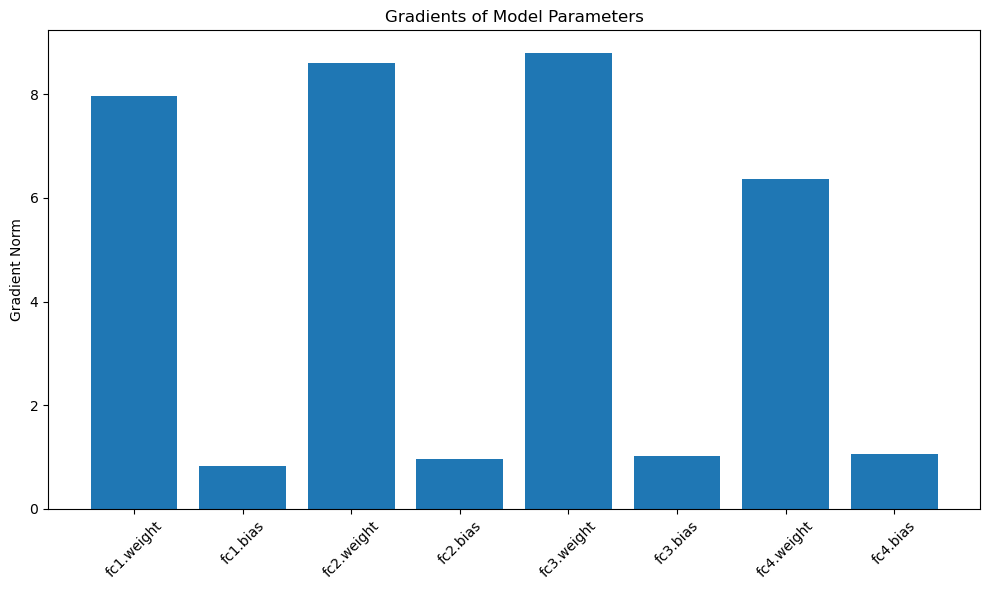

In [31]:
import torch.nn as nn
import torch.nn.init as init

class Model(nn.Module):
    def __init__(self):
       super(Model, self).__init__()
       self.fc1 = nn.Linear(201, 150)
       self.fc2 = nn.Linear(150, 100)
       self.fc3 = nn.Linear(100, 50)
       self.fc4 = nn.Linear(50, 1)
       self.relu = nn.ReLU()
       
       # Initialize weights using He initialization for each linear layer
       init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
       init.kaiming_normal_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
       init.kaiming_normal_(self.fc3.weight, mode='fan_in', nonlinearity='relu')
       init.kaiming_normal_(self.fc4.weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
        #x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = torch.exp(self.fc4(x)) # ensures all values are positive
        return x

# input size: [16, 12, 200]
model = Model()
print(model)

arr = torch.randn((16, 201))#12,200))
print(model(arr).shape)
nparm = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: " + str(nparm))

output = model(arr)

# Compute gradients
output.mean().backward()

# Plot gradients
gradient_list = []
parameter_names = []

for name, param in model.named_parameters():
    if param.grad is not None:
        gradient_list.append(param.grad.norm().item())
        parameter_names.append(name)

plt.figure(figsize=(10, 6))
plt.bar(parameter_names, gradient_list)
plt.ylabel('Gradient Norm')
plt.title('Gradients of Model Parameters')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [32]:
import torch.nn.functional as F

class CustomLoss_1(nn.Module):
    def __init__(self):
        super(CustomLoss_1, self).__init__()

    def forward(self, X_ji, C_j, Z_ji):
        #print(Z_ji)
        epsilon = 1e-8
        clipped_Z_ji = torch.clamp(Z_ji, epsilon)
        loss = X_ji * torch.log(clipped_Z_ji) + C_j * torch.exp(-clipped_Z_ji)
        # compute mean over batch to normalize due to varying batch sizes
        return (loss).mean()

In [ ]:
from sklearn.neighbors import KernelDensity
import torch.nn.functional as F

class CustomLoss_2(nn.Module):
    def __init__(self):
        super(CustomLoss_2, self).__init__()

    def forward(self, X_ji, C_j, Z_ji):
        #print(Z_ji)
        epsilon = 1e-8
        Z_ji = torch.clamp(Z_ji, epsilon)
        flat_Z_ji = Z_ji.view(-1)
        min_value = torch.min(flat_Z_ji)
        max_value = torch.max(flat_Z_ji)
        uniform_distribution = torch.ones_like(Z_ji) / (max_value - min_value)
        kde_Z_ji = torch.zeros_like(Z_ji, dtype=torch.float32)
        kde = KernelDensity(kernel='gaussian', bandwidth="silverman")#0.5)
        for i in range(Z_ji.shape[0]):
            sample = Z_ji[i].detach().numpy().reshape(-1, 1)  # Reshape to (200, 1)
            kde.fit(sample)
            kde_estimates = torch.exp(torch.tensor(kde.score_samples(sample), dtype=torch.float32))
            kde_Z_ji[i] = kde_estimates.squeeze()
            
        #kde = KernelDensity(kernel='gaussian', bandwidth=0.5)
        #kde.fit((Z_ji).detach().numpy())
        #kde_Z_ji = torch.exp(torch.tensor(kde.score_samples(Z_ji.detach().numpy()), dtype=torch.float32))
        weights = uniform_distribution / kde_Z_ji.unsqueeze(1)
        loss = X_ji * torch.log(Z_ji) + C_j * torch.exp(-Z_ji)
        # compute mean over batch to normalize due to varying batch sizes
        return (weights*loss).mean()

In [33]:
from sklearn.neighbors import KernelDensity

class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, X_ji, C_j, Z_ji):
        epsilon = 1e-8
        #print("Z_ji")
        #print(Z_ji)
        #kde = KernelDensity(kernel='gaussian', bandwidth=0.5)#bandwidth="silverman")
        #kde.fit((Z_ji).detach().numpy())
        #kde_Z_ji = torch.exp(torch.tensor(kde.score_samples(Z_ji.detach().numpy()), dtype=torch.float32))
        kde_X_ji = torch.zeros_like(X_ji, dtype=torch.float32)
        kde = KernelDensity(kernel='gaussian', bandwidth=0.5)#"silverman")
        for i in range(X_ji.shape[0]):
            sample = X_ji[i].detach().numpy().reshape(-1, 1)  # Reshape to (200, 1)
            kde.fit(sample)
            kde_estimates = torch.exp(torch.tensor(kde.score_samples(sample), dtype=torch.float32))
            kde_X_ji[i] = kde_estimates.squeeze()
        min_value = torch.min(kde_X_ji)
        max_value = torch.max(kde_X_ji)

        # Normalize the KDE values to the range [0, 1]
        normalized_kde_values = (kde_X_ji - min_value) / (max_value - min_value)
        weights = 1 - (0.9 * normalized_kde_values)
        weights = torch.clamp(weights, epsilon)
        weights_sum = torch.sum(weights)
        normalized_weights = weights / weights_sum
        epsilon = 1e-8
        Z_ji = torch.clamp(Z_ji, epsilon)
        loss = X_ji * torch.log(Z_ji) + C_j * torch.exp(-Z_ji)
        #print("loss")
        #print(loss)
        #print("weights")
        #print(normalized_weights)
        # compute mean over batch to normalize due to varying batch sizes
        return (normalized_weights*loss).mean()


In [34]:
def plot_data(targets, outputs):
    indices = range(len(targets[0]))

    fig, axs = plt.subplots(3, 3, figsize=(15,15))
    for i in range(3):
        for j in range(3):
            axs[i, j].scatter(indices, targets[i+j*3], s=5)
            axs[i, j].scatter(indices, outputs.detach().numpy()[i+j*3], s=5)
            axs[i, j].set_ylim(-0.25, 1.3)

    plt.xlabel('Index')
    plt.ylabel('Elongation Rates')
    plt.legend(['GLM Elongation Rate', 'NN Elongation Rate'], loc='upper center', bbox_to_anchor=(0.5, -0.6))


In [35]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

optimizer = optim.Adam(model.parameters(), lr=0.0001)

scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)


num_epochs = 50

loss_hist_train = [0] * num_epochs
loss_hist_valid = [0] * num_epochs

loss_fn = CustomLoss_1()#nn.L1Loss()#nn.MSELoss()

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}')
    model.train()
    for batch in trndl:
        optimizer.zero_grad()
        #Y_ji_batch = batch['Y_ji']
        X_ji_batch = batch['X_ji']
        C_j_batch = batch['C_j']
        outputs = model(X_ji_batch)
        loss = loss_fn(X_ji_batch, C_j_batch, outputs)
        #loss = loss_fn(batch['Z_ji'], outputs)
        loss.backward()
        optimizer.step()
        loss_hist_train[epoch] += loss.item()
        #if epoch == 49:
         #   plot_data(batch['Z_ji'], outputs)
    loss_hist_train[epoch] /= len(trndl.dataset)
    scheduler.step()
    
    #model.eval()
    #with torch.no_grad():
    #    for batch in valdl:
    #        Y_ji_batch = batch['Y_ji']
    #        X_ji_batch = batch['X_ji']
    #        C_j_batch = batch['C_j']
    #        outputs = model(Y_ji_batch)
    #        loss = loss_fn(X_ji_batch, C_j_batch, outputs)
            #loss = loss_fn(batch['Z_ji'], outputs)
    #        loss_hist_valid[epoch] += loss.item()
    #    loss_hist_valid[epoch] /= len(valdl.dataset)
    
    print(f'Epoch {epoch+1} trn_loss: '
          f'{loss_hist_train[epoch]:.4f}')# val_loss: '
          #f'{loss_hist_valid[epoch]:.4f}')

Epoch 1


RuntimeError: stack expects each tensor to be equal size, but got [28000] at entry 0 and [39620] at entry 1

In [ ]:
from matplotlib import pyplot as plt
epochs = range(1, len(loss_hist_train) + 1)
plt.plot(epochs, loss_hist_train, label='train_loss')
plt.plot(epochs, loss_hist_valid, label='valid_loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show 

In [ ]:
model.eval()

inputs = next(iter(trndl))#tstdl)) 
print("number of samples: " + str(len(inputs)))

with torch.no_grad():
    outputs = model(inputs['Y_ji'])
    
#outputs = torch.exp(outputs)
print(outputs)

targets = inputs['Z_ji']

plot_data(targets, outputs)

#for batch in trndl:
#    targets = inputs['Z_ji']
#    outputs = model(inputs['X_ji'])#'Y_ji'])
#    outputs = torch.exp(outputs)
    
#    plot_data(targets, outputs)